# TP 2 : Computer Vision

## Part 1 : segmentation

In this part of the TP, we are going to implement two approaches to image segmentation :

- algorithm of Otsu (histogram-based segmentation)
- a simple region-growing based algorithm

First, let us load some packages and define some helper functions (as in the previous TP)

(800, 586)

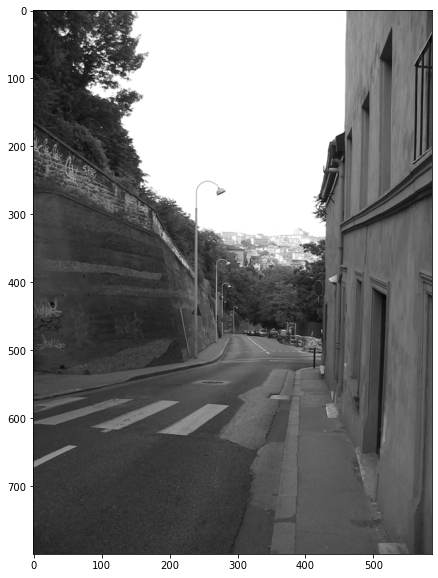

In [1]:
from matplotlib import pyplot as plt
import numpy as np 
import imageio
from skimage import color
is_colab = False

def read_image(file_name):
    img_color = imageio.imread(file_name)
    img_gray = color.rgb2gray(img_color)
    return img_gray,img_color
    
def write_image(img_in,file_name_out):
    imageio.imwrite(file_name_out, np.uint8(255.0*img_in))
    
def display_image(img_in):
    plt.figure(figsize=(10, 10))
    if (img_in.ndim == 2):
        plt.imshow(img_in,cmap='gray')
    elif (img_in.ndim == 3):
        # careful, in this case we supppose the pixel values are between 0 and 255
        plt.imshow(np.uint8(img_in))
    else:
        print('Error, unknown number of dimensions in image')
    return

file_dir = 'images/'
file_name = 'crossing'
file_ext = '.png'

if (is_colab == True):
  !wget "https://perso.telecom-paristech.fr/anewson/doc/images/crossing.png"
  img_gray,_ = read_image(file_name+file_ext)
else:
  img_gray,_ = read_image(file_dir+file_name+file_ext)

display_image(img_gray)
img_size = img_gray.shape
img_size

## Otsu's algorithm

Otsu's method is based on finding a threshold to split the image into two separate segments, based simply on their grey-level values. Since the maximum number of grey-levels is finite (and small, 256), we can use an exhaustive search.

The grey-level threshold is the one that minimises the following criterion :

$argmin_{\tau} \omega_0(\tau)\sigma_0(\tau) + \omega_1(\tau)\sigma_1(t)$

where

- $\sigma_0(\tau)$ and $\sigma_1(\tau)$ are the variances of the pixels in the first and second regions
- $\omega_0(\tau)$ and $\omega_1(\tau)$ are weights of the first and second regions

and 

- $\omega_0(\tau) = \sum_{p \in \Omega} \mathbb{1}_{\tau}(I(p)), \qquad$
- $\omega_1(\tau) = \sum_{p \in \Omega} 1-\mathbb{1}_{\tau}(I(p))$

and 

$\mathbb{1}_{\tau}(I(p)) =\begin{cases}
        1 \; \text{if} \: I(p)<=\tau\\
        0 \; \text{otherwise}
\end{cases}$

Implement this algorithm in a function called ``segmentation_otsu``. Note : only analyse thresholds which produce two distinct regions : you cannot have a region with no pixels. Furthemore, remember that the image is normalised between 0 and 1, with 256 discrete values. Choose the threshold values accordingly.

In [2]:
# This function returns the segmentation of the algorithm of otsu, as well as the threshold found
import math

def segmentation_otsu(img):
    img_in = img.copy()
    Omega = img_in.shape[0]*img_in.shape[1]
    otsu = []
    std0, std1 = np.array([]), np.array([])

    for threshold in range(1,255):

        tau = threshold / 256
        values, counts = np.unique(img_in<=tau,return_counts=True)
        w0 = counts[np.argmax(values)]
        w1 = Omega - w0
        
        std0 = img_in[img_in<=tau]
        std1 = img_in[img_in>tau]

        otsu.append(w0*np.std(std0)+w1*np.std(std1))
    
    threshold_out = np.argmin(otsu)
    tau_out = threshold_out/256            
    img_out_otsu = np.multiply(np.ones(img_in.shape),img_in>tau_out)

    return img_out_otsu,tau_out

Carry out the segmentation on the input image and display the result

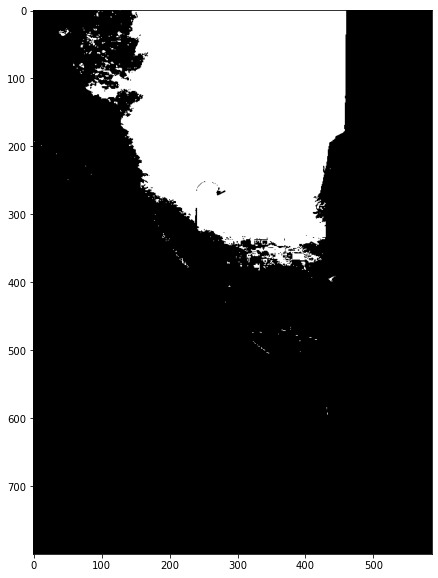

In [3]:
img_out_otsu,tau = segmentation_otsu(img_gray)
display_image(img_out_otsu)
write_image(img_out_otsu,file_name+'_segmentation_otsu.png')

__Question__ What problem can you see with the segmentation result ? What morphological technique(s) (seen in the lesson) could you use to clean the result up ? 

__Answer__ 

- We can see in the white part a lots of black holes (they should not be in the background). Thus I want to have uniform parts, then I will fill the small black holes in white thanks to the closing morphological technique and then use the opening to eliminate the white holes in the black background space.

- In the same idea we can see in the black parts small blank points. Thus I will apply opening to have a uniform black part and get rid of the white points in the foreback.

Carry out this technique to clean up the output image, and imwrite the result. You can find the necessary function(s) in the following package :

skimage.morphology

Choose the neighbourhood parameter of the functions to obtain the best results.

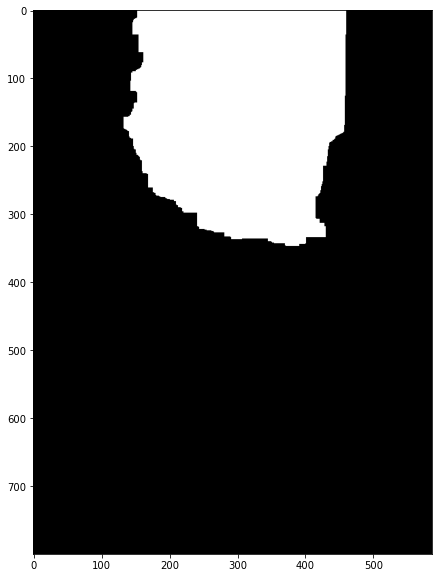

In [4]:
from skimage.morphology import opening, closing

struct_size = 15
struct_el = np.ones((struct_size,struct_size))
img_out_otsu_cleaned = closing(opening(img_out_otsu,selem=struct_el),selem=struct_el)

display_image(img_out_otsu_cleaned)
write_image(img_out_otsu_cleaned,file_name+'_segmentation_otsu_cleaned_1.png')

__Question__ In which order did you propose to carry out the morphological operations ? Why ?

__Answer__

I prefer to do in first the closing, because: 

Since I have a much more of white holes in the black space than black holes in the white space if I do the opening in the first place, I take the risk that white holes begins to take on the black foreground space with the opening that erase blank points.

To illustrate my answer :

You should see that the whit space is too large if you do the opening in the first place.

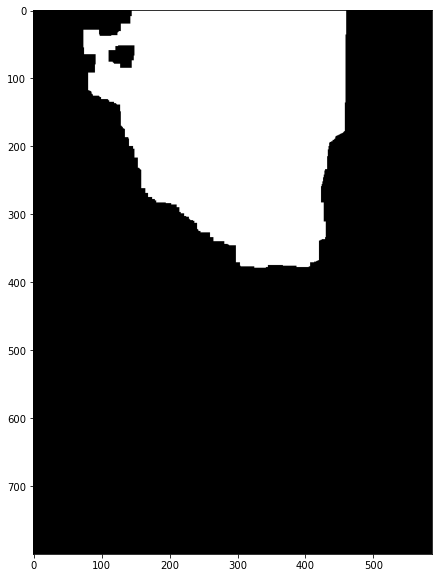

In [5]:
img_out_otsu_bad_cleaning = opening(closing(img_out_otsu,selem=struct_el),selem=struct_el)

display_image(img_out_otsu_bad_cleaning)

Let's change the image, and carry out the segmentation again.

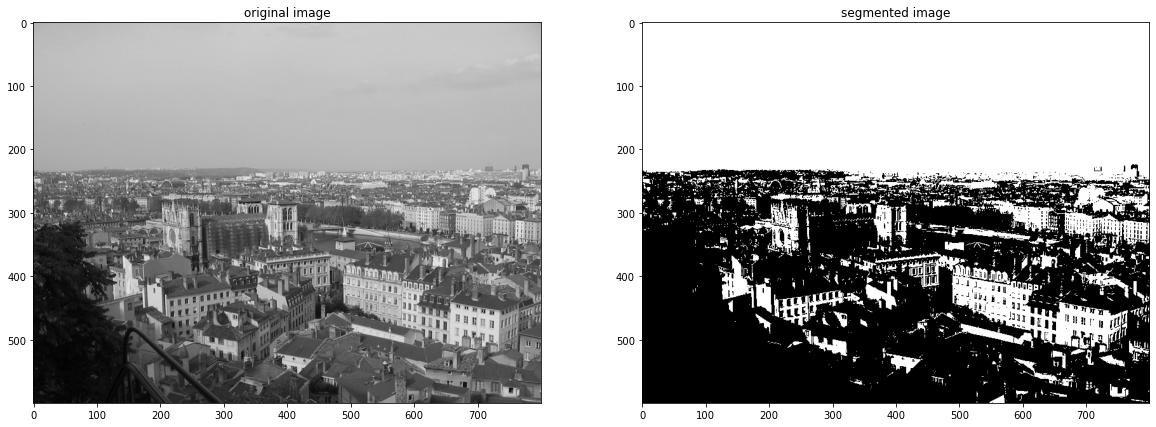

In [6]:
file_dir = 'images/'
file_name = 'town'
file_ext = '.png'

if (is_colab == True):
  !wget "https://perso.telecom-paristech.fr/anewson/doc/images/town.png"
  img_gray,_ = read_image(file_name+file_ext)
else:
  img_gray,_ = read_image(file_dir+file_name+file_ext)

img_size = img_gray.shape
img_out_otsu,tau = segmentation_otsu(img_gray)
write_image(img_out_otsu,file_name+'_segmentation_otsu.png')

fig = plt.figure(figsize=(20,20))

fig.add_subplot(1,2,1)
plt.imshow(img_gray,cmap='gray')
plt.title('original image')

fig.add_subplot(1,2,2)
plt.imshow(img_out_otsu,cmap='gray')
plt.title('segmented image')
plt.show()

As we can see, there is no notion of connectivity in the algorithm of Otsu (two regions far away can be in the same segment). For such a notion, we turn to region merging.

## Region merging

The region merging algorithm is quite simple : we start with a small region, and add new pixels progressively to the region. More precisely, at each iteration of the algorithm, we attempt to add the neighbours of the pixels in the current segmentation. We add new pixels according to the criterion :

- $I(p)$ is added to the region if the absolute difference between the pixel value and the region's average value is less than a threshold value (which you must set).

First, create a function called ``initialize_segmentation`` which initialises the segmentation with a small circular region centred on a given seed point (the seed point is an input). For this, the following function :

- scipy.ndimage.morphology.distance_transform_edt

can be useful.

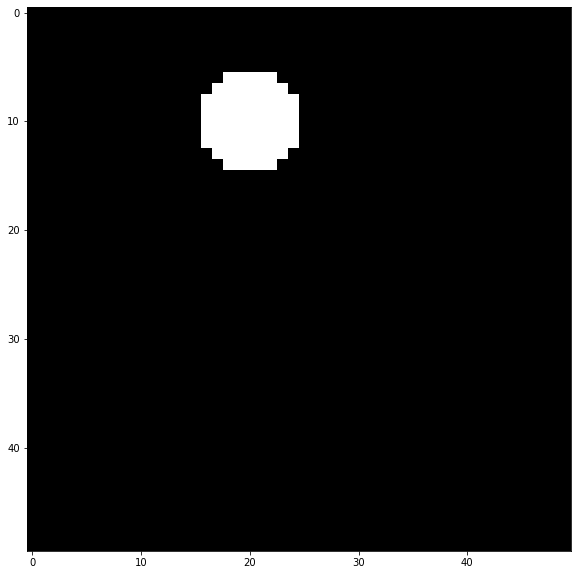

In [7]:
from scipy.ndimage.morphology import distance_transform_edt

def initialize_segmentation(seed_pt,img_shape):
    img_seed = np.ones(img_shape)
    img_seed[seed_pt]=0
    distance = distance_transform_edt(img_seed)
    R = 5
    seg_init = np.multiply(np.ones(img_shape),distance<R)
    return seg_init

#Lets test it !
display_image(initialize_segmentation(seed_pt=(10,20),img_shape=(50,50)))

Now, create a function called ``segmentation_region_growing`` which carries out the region growing algorithm, with the criterion above, and which uses the ``initialize_segmentation`` function. Again, the functions from ``scipy.ndimage.morphology`` can be useful here.

__IMPORTANT NOTE__ Once a pixel has been added to the region, it is in the region permanently : it is not checked again in further iterations (otherwise we could remove pixels which were added).

In [8]:
from scipy.ndimage import binary_dilation

def neighbourhood(seg):
    neighbours = distance_transform_edt(seg)

    # adding the closer pixels to the neighbourhodd : 
    neighbours[neighbours>10]=1 
    neighbours[neighbours<=10]=0

    neighbourhood = neighbours
    return neighbourhood


# This function returns both the final segmentation and the initialisation
def segmentation_region_growing(img,seed_pt,tau):

    seg_init = initialize_segmentation(seed_pt, img.shape)
    new_seg = seg_init.copy()
    old_seg = new_seg.copy()

    area_growing = True
    while area_growing:
        neiborhood = neighbourhood(new_seg)
        average = img[new_seg>0].mean()
        index_neiborhood = np.argwhere(neiborhood==True)
        
        for index in index_neiborhood:
            if np.abs(img[index[0]][index[1]] - average)< tau:
                new_seg[index[0]][index[1]]=1
        area_not_growing = (old_seg == new_seg).all()

        if area_not_growing:
            area_growing = False

        old_seg=new_seg.copy()
    
    struct_size = 25
    struct_el = np.ones((struct_size,struct_size))
    seg = closing(opening(img_out_otsu,selem=struct_el),selem=struct_el)

    return seg,seg_init

Carry out the segmentation on the input image with the seed point and threshold specified in the following code :

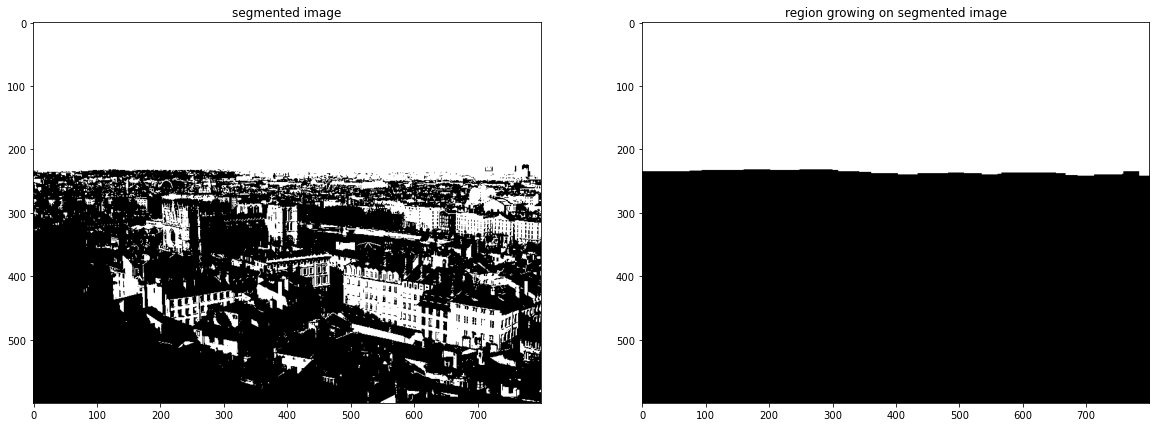

In [11]:
seed_pt = np.asarray([130,350])
tau = 20.0 * (1.0/256.0)
img_out_region_growing,seg_init = segmentation_region_growing(img_gray,seed_pt,tau)

#write the img_out_region_growing in a file :
write_image(seg_init,file_name+'_segmentation_region_growing_init.png')
write_image(img_out_region_growing,file_name+'_segmentation_region_growing.png')

fig = plt.figure(figsize=(20,20))

fig.add_subplot(1,2,1)
plt.imshow(img_out_otsu,cmap='gray')
plt.title('segmented image')

#show img_out_region_growing image 
fig.add_subplot(1,2,2)
plt.imshow(img_out_region_growing,cmap='gray')
plt.title('region growing on segmented image')

plt.show()